# Recalage difféomorphique de densités: Applications 
Youcef Akrout, Antoine Commaret et Amyn Kassara

Le but de ce Notebook est d'appliquer les méthodes proposées par le papier: "Diffeomorphic Density Registration" de Martin Bauer, Sarang Joshi et Klas Modin sur différentes images, afin de montrer les avantages ainsi que les limites des modèles. 

Les algorithmes utilisés ont été implémentés par Monsieur Klas Modin et sont en libre accès sur sa page github (https://github.com/kmodin/ddmatch/tree/master/ddmatch). Nous utiliserons plus précisemment la librairie ddmatch, pour Diffeomorphic deformations for shape matching, qui est une libraire Python pour le recalage d'images et plus généralement pour la correspondance de formes. Cette librairie utilise des difféomorphismes pour déformer des formes "sources" vers des formes "cibles". Les images seront modélisées par des densités de probabilités. 

Nous tenons aussi à préciser que, bien que ce projet soit initialement dans le cadre du cours d'Imagerie médicale, nous proposerons des images plus générales, notre objectif étant surtout de montrer les qualités et les limites du modèle.

In [134]:
!git clone https://github.com/kmodin/ddmatch.git
!pip install ffmpeg

fatal: destination path 'ddmatch' already exists and is not an empty directory.


  Created wheel for ffmpeg: filename=ffmpeg-1.4-cp37-none-any.whl size=6089 sha256=2ccda75ac8dce3a08f456bf5affd5ab50ef0dd458c0109fdc489473496941468
  Stored in directory: C:\Users\kassa\AppData\Local\pip\Cache\wheels\b6\68\c3\a05a35f647ba871e5572b9bbfc0b95fd1c6637a2219f959e7a
Successfully built ffmpeg


## Initialisation

In [335]:
import numpy as np
import pylab as plt
from matplotlib import colors
from math import *
import numba
from matplotlib import *

##  Echantillonnage d'une distribution de probabilités non uniforme:

Pour ce premier exemple, nous allons montrer un cas où modéliser le problème de recalage difféomorphique par un problème de Transport Optimal d'Information, où la condition de compatibilité de la métrique d'origine est respectée, est pertinent. On rappelle alors que trouver le difféomorphisme optimal revient à résoudre un système d'équations de Poisson (cf Section 3.3 du rapport).

L'objectif de cette partie est de générer $N$ échantillons aléatoire à partir d'une distribution de probabilité $\rho_1$. L'idée est de générer des échantillons d'une distribution uniforme $\rho_0$ puis de trouver un difféomorphisme, grâce au problème de transport d'information optimal,  qui déforme cette densité source pour là transformer en densité cible $\rho_1$.

On considère, comme proposé dans le papier étudié d'appliquer cette méthode à $\rho_1$ tel que:

$$\rho_1= (1-0.8\cos{x}\cos{2y})dx dy$$



In [271]:
from ddmatch import *


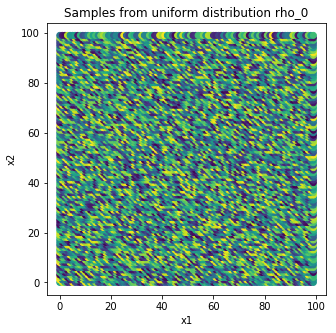

In [125]:
#we create a source density. A source density can be modelled by a 2D array. We consider the uniform density of R^2.
#We consider images of size 100*100
rho_0 =1/100*np.ones((100,100))

#Here we show 100*100 samples from uniform distribution:
N_samples=100
rho_0_samples= np.eye(N_samples)
for i in range(N_samples):
    for j in range(N_samples):
        rho_0_samples[i][j]=np.random.uniform(0,1)
#plot the source image
fig, ax = plt.subplots(figsize=(5, 5))
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Samples from uniform distribution rho_0')
x = np.array([i for i in range(100)])
y= np.array([i for i in range(100)])
X,Y = np.meshgrid(x, y)
plt.scatter(X,Y,c=rho_0_samples[X,Y])
plt.show()


In [147]:
#Ici, on cree la densite cible
x1= np.linspace(-np.pi,np.pi,100)
y1= np.linspace(-np.pi,np.pi,100)
rho_1= [[1-0.8*np.cos(x1[i])*np.cos(2*y1[i]) for i in range(100)] for i in range(100) ]
rho_1=np.array(rho_1)
#rho_0 et rho_1 doivent avoir la meme masse totale(theoreme de Moser):
a=(rho_0_samples.sum()/rho_1.sum())
rho_1= a*rho_1

In [148]:
diff=CompatibleConformalDensityMatching(source=rho_0_samples,target=rho_1, compute_phi=True)
diff.run()

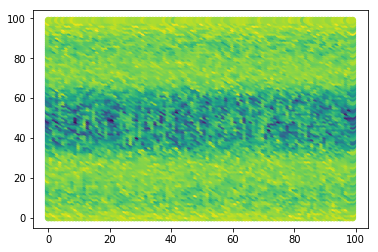

In [153]:
##Lorsqu on applique le difféomophisme optimal sr l'image source, on obtient diff.I
x = np.array([i for i in range(100)])
y= np.array([i for i in range(100)])
X,Y = np.meshgrid(x, y)
plt.scatter(X,Y,c=diff.I[X,Y])
plt.show()

##  Limites du modèle:

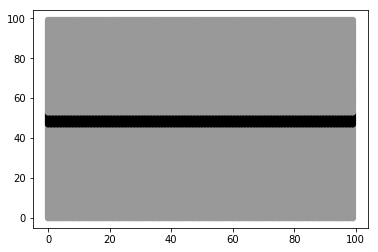

In [360]:
#Notre modèle ne permet que des densité strictement positives, donc le fond ne sera pas nul
I0=[[0.4 for i in range(100)] for j in range(100)]
for i in range(100):
    for j in range(-3,3):
        I0[i][50+j]=1.0
I0=np.array(I0)
x = np.array([i for i in range(100)])
y= np.array([i for i in range(100)])
X,Y = np.meshgrid(x, y)
normalize = colors.Normalize(vmin=0, vmax=1)
plt.scatter(X,Y,c=I0[X,Y],cmap='gray_r',norm=normalize)
plt.show()


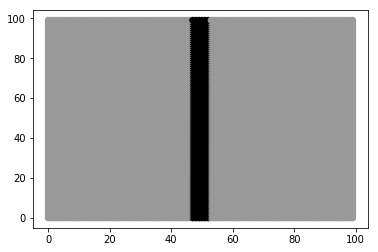

In [361]:
I1=[[0.4 for i in range(100)] for j in range(100)]
for j in range(100):
    for i in range(-3,3):
        I1[50+i][j]=1.0
I1=np.array(I1)
x = np.array([i for i in range(100)])
y= np.array([i for i in range(100)])
X,Y = np.meshgrid(x, y)
normalize = colors.Normalize(vmin=0, vmax=1)
plt.scatter(X,Y,c=I1[X,Y],cmap='gray_r', norm= normalize)
plt.show()

In [364]:
#Ici, les deux distributions ont la même masse totale
diff=CompatibleConformalDensityMatching(source=I0,target=I1, compute_phi=True)
diff.run(epsilon=0.001)


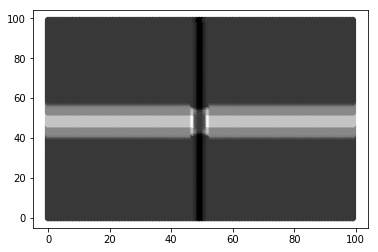

In [365]:
#Lorsqu'on applique le difféomophisme optimal sr l'image source, on obtient diff.I

x = np.array([i for i in range(100)])
y= np.array([i for i in range(100)])
X,Y = np.meshgrid(x, y)
plt.scatter(X,Y,c=diff.I[X,Y],cmap='gray_r')
plt.show()

On remarque qu'au lieu de transporter les pixels mauves vers les pixels jaunes, le difféomorphisme optimal produit des pixels en compressant les pixels déjà existants. Ce phénomène est illustré et expliqué sur le rapport.